In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [2]:
data=pd.read_csv("Stress.csv")

In [3]:
data.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [5]:
data.describe()

,label,confidence,social_timestamp
count,2838.000000,2838.000000,2.838000e+03
mean,0.524313,0.808972,1.518107e+09
std,0.499497,0.177038,1.552209e+07
min,0.000000,0.428571,1.483274e+09
25%,0.000000,0.600000,1.509698e+09
50%,1.000000,0.800000,1.517066e+09
75%,1.000000,1.000000,1.530898e+09
max,1.000000,1.000000,1.542592e+09


In [6]:
data.isnull().sum()

subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64

In [7]:
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to /home/divum/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words("english"))

In [9]:
def clean(text):
    text=str(text).lower()
    text=re.sub('\[.*?\]','',text)
    text=re.sub('https?://\S+www\.\S+','',text)
    text=re.sub('<.*?>+','',text)
    text=re.sub('[%s]' % re.escape(string.punctuation),'',text)
    text=re.sub('\n','',text)
    text=re.sub('\w*\d\w*','',text)
    text=[word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    return text


In [10]:
data["text"]=data["text"].apply(clean)

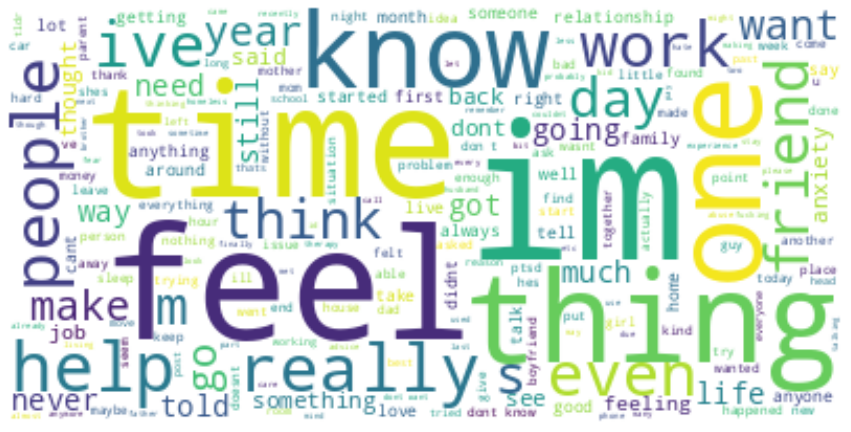

In [12]:
text=" ".join( i for i in data.text)
stopwords=set(STOPWORDS)
wordcloud=WordCloud(stopwords=stopwords,background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()


In [13]:
data


,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)",said felt way suggeted go rest trigger ahead y...,1,0.800000,1521614353
1,assistance,8lbrx9,"(0, 5)",hey rassistance sure right place post goes im...,0,1.000000,1527009817
2,ptsd,9ch1zh,"(15, 20)",mom hit newspaper shocked would knows dont lik...,1,0.800000,1535935605
3,relationships,7rorpp,"[5, 10]",met new boyfriend amazing kind sweet good stud...,1,0.600000,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",october domestic violence awareness month dome...,1,0.800000,1539809005
...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]",week ago precious ignored jan happy year pr...,0,1.000000,1515187044
2834,ptsd,9p4ung,"[20, 25]",dont ability cope anymore im trying lot things...,1,1.000000,1539827412
2835,anxiety,9nam6l,"(5, 10)",case first time youre reading post looking peo...,0,1.000000,1539269312
2836,almosthomeless,5y53ya,"[5, 10]",find normal good relationship main problem see...,0,0.571429,1488938143


In [14]:
data["new_label"]=data["label"].map({0:"No Stress",1:"Stress"})
data=data[["text","new_label"]]
data.head()

,text,new_label
0,said felt way suggeted go rest trigger ahead y...,Stress
1,hey rassistance sure right place post goes im...,No Stress
2,mom hit newspaper shocked would knows dont lik...,Stress
3,met new boyfriend amazing kind sweet good stud...,Stress
4,october domestic violence awareness month dome...,Stress


In [15]:
x=np.array(data["text"])
y=np.array(data["new_label"])


In [16]:
cv=CountVectorizer()

In [17]:
X=cv.fit_transform(x)

In [18]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=11)

In [19]:
model=BernoulliNB()
model.fit(x_train,y_train)

BernoulliNB()

In [20]:
y_pre=model.predict(x_test)

In [21]:
y_pre

array(['No Stress', 'Stress', 'Stress', 'Stress', 'Stress', 'Stress',
       'No Stress', 'No Stress', 'Stress', 'Stress', 'Stress',
       'No Stress', 'No Stress', 'Stress', 'No Stress', 'No Stress',
       'Stress', 'No Stress', 'No Stress', 'Stress', 'Stress',
       'No Stress', 'Stress', 'Stress', 'Stress', 'Stress', 'No Stress',
       'Stress', 'Stress', 'Stress', 'Stress', 'Stress', 'No Stress',
       'Stress', 'Stress', 'No Stress', 'Stress', 'Stress', 'No Stress',
       'Stress', 'Stress', 'No Stress', 'Stress', 'No Stress',
       'No Stress', 'No Stress', 'Stress', 'Stress', 'Stress',
       'No Stress', 'No Stress', 'Stress', 'No Stress', 'Stress',
       'Stress', 'Stress', 'No Stress', 'No Stress', 'Stress',
       'No Stress', 'Stress', 'No Stress', 'No Stress', 'Stress',
       'Stress', 'Stress', 'Stress', 'Stress', 'No Stress', 'Stress',
       'Stress', 'Stress', 'Stress', 'No Stress', 'Stress', 'No Stress',
       'Stress', 'Stress', 'Stress', 'Stress', 'No Stre

In [22]:
print(classification_report(y_pre,y_test))

              precision    recall  f1-score   support

   No Stress       0.61      0.75      0.67       109
      Stress       0.82      0.70      0.75       175

    accuracy                           0.72       284
   macro avg       0.71      0.72      0.71       284
weighted avg       0.74      0.72      0.72       284



In [23]:
MN_Model=MultinomialNB()

In [24]:
MN_Model.fit(x_train,y_train)

MultinomialNB()

In [25]:
mn_pre=MN_Model.predict(x_test)

In [26]:
print(classification_report(mn_pre,y_test))

              precision    recall  f1-score   support

   No Stress       0.59      0.77      0.67       104
      Stress       0.84      0.69      0.76       180

    accuracy                           0.72       284
   macro avg       0.72      0.73      0.71       284
weighted avg       0.75      0.72      0.73       284



In [27]:
from sklearn.svm import SVC

In [28]:
model_svc=SVC()

In [29]:
model_svc.fit(x_train,y_train)

SVC()

In [30]:
pre_svc=model_svc.predict(x_test)

In [31]:
print(classification_report(pre_svc,y_test))

              precision    recall  f1-score   support

   No Stress       0.73      0.70      0.71       142
      Stress       0.71      0.75      0.73       142

    accuracy                           0.72       284
   macro avg       0.72      0.72      0.72       284
weighted avg       0.72      0.72      0.72       284



# Testing the model

In [46]:
user=input("Text : ")
data=cv.transform([user]).toarray()
out=MN_Model.predict(data)
for i in out:
    print("the user in ",*out)

Text : you ate yesterday without calling me
the user in  No Stress
